<a href="https://colab.research.google.com/github/widifadi/SEERI-Building_Segmentation/blob/main/SEERI_Building_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Functions

## Install and Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# To Install the Libraries without Displaying Installation Messages
%%capture

# Install required library:
# General Usage and Data Handling
!pip install rasterio
!pip install geopandas

# Split Folders for Separating Training, Test, and Validation Data
!pip install split-folders

# Translator for Vector and Raster Geospatial Data Format
!apt install gdal-bin python-gdal python3-gdal
!pip install gdal

# Segmentation libraries
!pip install -q -U segmentation-models-pytorch==0.2.0 albumentations==1.0.0

# For Converting Prediction Model to ONNX format
!pip install onnx

# GeoPatch by Hejarshahabi
# !pip install GeoPatch
# !pip install -Uqq ipdb
# !pip install patchify

In [3]:
# Import library, files, and display the data

# General Usage for Processing and Data Handling
import os, cv2, glob
import numpy as np
import pandas as pd
import random, tqdm

import warnings
warnings.filterwarnings("ignore")

# For Image Handling
import rasterio as rs
import tifffile as tiff
import rasterio.features
from rasterio.features import geometry_mask
from rasterio.merge import merge

# For Splitting Data Folders to Train, Test, and Validation
import splitfolders

# For Deep Learning Model Training and Handling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import torch.onnx as onnx

# For Plotting Images and Graphs
# import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# For Geospatial Data Conversion and Handling
from osgeo import gdal
import geopandas as gpd
from shapely.geometry import shape as shp

# import ipdb
# from matplotlib.patches import Rectangle
# from patchify import patchify
# from PIL import Image
# from rasterio.enums import Resampling
# from rasterio.transform import Affine
# import folium
# from folium import plugins
# import time
# from IPython.display import clear_output
# import json
# import datetime
# import fnmatch
# import re
# from pycococreatortools import pycococreatortools
# from pycocotools.coco import COCO

## Necessary Functions

### Image Handling Functions

In [25]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image): # (image, class_names, threshold=0.7) | (image)
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[512,512,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

# Alpha Channel Emitter
def alpha_emit(rgba_loc, rgb_loc):
  """
  Emit alpha channel from RGBA Image
  """
  try:
      # Open the input raster file
      dataset = gdal.Open(rgba_loc)

      if dataset is None:
          raise ValueError('Failed to open the raster file.')

      # Retrieve the number of bands in the dataset
      num_bands = dataset.RasterCount

      # Create a new GDAL driver to write the output raster without an alpha channel
      driver = gdal.GetDriverByName('GTiff')

      # Create a new dataset with the same dimensions, but without the alpha channel
      new_dataset = driver.CreateCopy(rgb_loc, dataset, 0)

      # Loop over each band in the original dataset, excluding the alpha channel, and write the band data to the new dataset
      for band_index in range(1, num_bands):  # Exclude band 1 (alpha channel)
          band = dataset.GetRasterBand(band_index)
          new_dataset.GetRasterBand(band_index).WriteArray(band.ReadAsArray())

      # Close the datasets
      dataset = None
      new_dataset = None

      print("RGBA image converted to RGB successfully.")

  except Exception as e:
      print("An error occurred:", str(e))

# Perform Image Scalling
def img_scalling(rgba_loc, rgb_loc):
  """
  Scaling Uint16 RGB to Uint8 RGB
  """
  scl_img = rgba_loc

  with rs.open(scl_img) as img:
    image = img.read()
    # image = np.transpose(image, (1,2,0))

  r_image = image[0, :, :]
  nor_r_image = np.uint8((r_image/np.max(r_image)) * 255)
  g_image = image[1, :, :]
  nor_g_image = np.uint8((g_image/np.max(g_image)) * 255)
  b_image = image[2, :, :]
  nor_b_image = np.uint8((b_image/np.max(b_image)) * 255)
  nor_image = np.dstack((nor_r_image, nor_g_image, nor_b_image))
  nor_image = np.transpose(nor_image, (2,0,1))

  with rs.open(rgb_loc, 'w', driver='GTiff', width=img.width, height=img.height,
                   count=3, crs=img.crs, transform=img.transform, dtype=rs.uint8) as dst:
    dst.write(nor_image)

# Perform Image Stretching
def stretch_image_brightness(image_path, output_path):
    with rs.open(image_path) as src:
        image = src.read()
        transformed = np.sqrt(image)
        normalized = transformed / np.max(transformed)
        scaled = normalized * 255
        scaled = scaled.astype(np.uint8)

        profile = src.profile.copy()
        profile.update(dtype=rs.uint8, count=3)

        with rs.open(output_path, 'w', **profile) as dst:
            dst.write(scaled)

# Perform leftmost corner coordinate extraction
def img_coord(image):
  """
  Extract upperleft corner coordinate
  """
  img_info = []
  with rs.open(image) as img:
    rows, cols = img.shape
    ulc_x = img.transform[2]
    ulc_y = img.transform[5]
    gsd_x = img.transform[0]
    gsd_y = img.transform[4]

    img_info.extend([rows, cols, ulc_x, ulc_y, gsd_x, gsd_y])

  return img_info

# Automatically create folder structure in google colab
def create_folder_structure(root_dir, project_name):
    # Define the root directory path in Google Drive
    root_dir = root_dir + project_name

    # Define the folder structure
    folder_structure = [
        'model/bss_model',
        'model/pretrained_weights_gan',
        'original_data/img/rgb',
        'original_data/mask',
        'original_data/shp/building_shp',
        'product/folder',
        'product/mosaic',
        'product/prediction',
        'product/regularized_imgs',
        'product/sample_predictions',
        'product/shp',
        'png',
        'tiff/_prep/pred_data'
    ]

    # Create the folder structure in Google Colab
    for folder_path in folder_structure:
        folder_path = os.path.join(root_dir, folder_path)
        os.makedirs(folder_path, exist_ok=True)

    print(f'Folder structure for project "{project_name}" created in Google Colab.')

### GeoPatch

Patching satellite imagery into smaller sizes, storing the result in label and patch folder for **training** deep learning models or storing the result in prediction patch folder for **predicting** the images

In [5]:
#@title
# -*- coding: utf-8 -*-
"""
GeoPatch: https://github.com/Hejarshahabi/GeoPatch/tree/main
Created on Dec 15 2022

@author: hejar Shahabi
Email: hejarshahabi@gmail.com

Edited by Fadilah W A on Jul 2023
"""


class TrainPatch:
    """
    Using the package, you will be able to turn
    satellite imagery into patches with various shape sizes
    and apply data augmentation techniques such as flip and rotation.

    parameters:
    -----------
    image:              NumPy array, or string that
                        shows path to satellite imagery with "tif" format

    label:              NumPy array, or string that
                        shows path to label raster with "tif" format

    patch_size:         Integer
                        moving window size to generate image patches
                        From example: for a 128*128 patch just 128 needs to be passed

    stride:             Integer
                        For small images or large patch size it is recommended to have
                        a stride value less than patch size to generate more image patches
                        and also having overly with consecutive patches. in case of no overly pass
                        stride value equal or bigger than patch size.

    channel_first:     Boolean
                       True if the first index is the number of image bands and False if it is the last index.

    """

    def __init__(self, image=None, label=None, patch_size=None, stride=None, channel_first=True):
        self.image=image
        self.label=label
        self.patch_size=patch_size
        self.stride=stride
        self.channel=channel_first
    def readData(self):
        if type(self.image)==str and self.image[-3:]=="tif":
            self.img=rs.open(self.image)
            self.band=self.img.count
            self.row =self.img.width
            self.col = self.img.height
            self.imgarr=self.img.read()
            self.shape=self.imgarr.shape
            self.inv=rs.open(self.label)
            self.inv_band=self.inv.count
            self.inv_row =self.inv.width
            self.inv_col = self.inv.height
            self.inv=self.inv.read()
            if self.channel==True:
                self.imgarr=self.imgarr
                self.inv=self.inv
            else:
                self.imgarr=np.transpose(self.imgarr,(2,0,1))
                self.inv=np.transpose(self.inv,(2,0,1))
            return self.imgarr, self.inv

        elif type(self.image)==str and self.image[-3:]=="npy":
            self.imgarr=np.load(self.image)
            self.shape=self.imgarr.shape
            self.inv=np.load(self.label)
            if self.channel==True:
                self.imgarr=self.imgarr
                self.inv=self.inv
            else:
                self.imgarr=np.transpose(self.imgarr,(2,0,1))
                self.inv=np.transpose(self.inv,(2,0,1))
            return self.imgarr, self.inv

        else:
            self.shape=self.image.shape
            if self.channel==True:
                self.imgarr=self.image
                self.inv=self.inv
            else:
                self.imgarr=np.transpose(self.image,(2,0,1))
                self.inv=np.transpose(self.inv,(2,0,1))

            self.inv=self.label
            return self.imgarr, self.inv, self.shape


    def data_dimension(self):
        """
        To display input data dimension
        """
        self.readData()
        print("############################################")
        print(f' the shape of image is: {self.shape} ')
        print(f' the shape of label is: {self.inv.shape} ')
        print("############################################")

    def patch_info(self):
        """
        To Display the number of orginal image patches can be
        generated based on given patch size and stride values.
        """
        self.readData()
        x_dim=self.imgarr.shape[1]
        y_dim=self.imgarr.shape[2]

        self.X=x_dim
        self.Y=y_dim
        self.covx=self.X+self.patch_size
        self.covy=self.Y+self.patch_size
        self.total_patches= ((x_dim)//self.stride)*((y_dim)//self.stride)


        print("       ")
        print("#######################################################################################")
        print(f'The effective X-dimension of the input data for patch generation is from 0 to {self.covx}')
        print(f'The effective Y-dimension of the input data for patch generation is from 0 to {self.covy}')
        print(f'The number of total non-augmented patches that can be generated\n'
              f'based on patch size ({self.patch_size}*{self.patch_size}) and stride ({self.stride}) is "{self.total_patches}"')

        print("#######################################################################################")
        print("                                                                        ")
        #print("#######################################################################################")


    def save_Geotif(self, folder_name="tif", only_label=False):
        #self.patch_info()


        """

        parameters:
        -----------
        folder_name:        String
                            Passing the folder name as string like "tif" so a folder
                            with that name will be generated in the current working directory
                            to save Geotif image patches there in the sub-folders called "patch" and "label"

        only_label:         Boolean
                            If True, only the patches will be exported that have labelled data.

        """

        if not os.path.exists(folder_name+"/patch"):
                                  os.makedirs(folder_name+"/patch")
                                  os.makedirs(folder_name+"/label")

        with tqdm.tqdm(range(self.total_patches), desc="Patch Counter", unit=" Patch") as pbar:
            index=1
            patch_counter=0
            for i in (range(0,self.X+self.stride,self.stride)):
                for j in (range(0,self.Y+self.stride,self.stride)):
                    self.img_patch= self.imgarr[:,i:i+self.patch_size,j:j+self.patch_size]
                    self.lbl_patch= self.inv[:,i:i+self.patch_size,j:j+self.patch_size]
                    if only_label==True:
                        # if self.lbl_patch.any()<1:
                        #     continue
                        self.x_cord,self.y_cord = (j*self.img.transform[0]+self.img.transform[2]),(self.img.transform[5]+i*self.img.transform[4])
                        transform= [self.img.transform[0],0,self.x_cord,0,self.img.transform[4],self.y_cord]

                        with rs.open(folder_name+"/patch/"+str(index)+"_img.tif","w",driver='GTiff', count=self.band, dtype=self.imgarr.dtype,
                                          width=self.patch_size, height=self.patch_size, transform=transform, crs=self.img.crs) as raschip:
                                raschip.write(self.img_patch)
                        with rs.open(folder_name+"/label/"+str(index)+"_lbl.tif","w",driver='GTiff', count=self.inv_band, dtype=self.inv.dtype,
                                          width=self.patch_size, height=self.patch_size, transform=transform, crs=self.img.crs) as lblchip:
                                lblchip.write(self.lbl_patch)
                                patch_counter+=1
                        index+=1
                        pbar.update(1)

                    if only_label==False:

                        self.x_cord,self.y_cord = (j*self.img.transform[0]+self.img.transform[2]),(self.img.transform[5]+i*self.img.transform[4])
                        transform= [self.img.transform[0],0,self.x_cord,0,self.img.transform[4],self.y_cord]

                        with rs.open(folder_name+"/patch/"+str(index)+"_img.tif","w",driver='GTiff', count=self.band, dtype=self.imgarr.dtype,
                                          width=self.patch_size, height=self.patch_size, transform=transform, crs=self.img.crs) as raschip:
                                raschip.write(self.img_patch)
                        with rs.open(folder_name+"/label/"+str(index)+"_lbl.tif","w",driver='GTiff', count=self.inv_band, dtype=self.inv.dtype,
                                          width=self.patch_size, height=self.patch_size, transform=transform, crs=self.img.crs) as lblchip:
                                lblchip.write(self.lbl_patch)
                                patch_counter+=1

                        index+=1
                        pbar.update(1)
            total_patches=pbar.total
            save_patches=patch_counter
            percentage= int((save_patches/total_patches)*100)
            print("#######################################################################################")
            print(f'{save_patches} patches, which are %{percentage} of totall patches, are saved as ".tif" format in "{os.getcwd()}\{folder_name}"')
            print("#######################################################################################")


    def save_numpy(self, folder_name="npy", only_label=True, return_stacked=True, save_stack=True,  V_flip=True, H_flip=True, Rotation=True):
        #self.patch_info()
        #self.patch_info()
        """
        Using this function image patches will be generated in NumPy format with data augmentation options.

        parameters :
        -----------
        folder_name:        String
                            Passing the folder name as string like "npy" so a folder
                            with that name will be generated in the current working directory
                            to save image patches in NumPy format there in the sub-folders called "patch" and "label"

        only_label:         Boolean
                            If True, only the patches will be exported that have labelled data.

        Return_stacked:     Boolean
                            if True, the generated patches will be stacked to gather as a NumPy array

        save_stacked :     Boolean
                            If True, the stacked arrays of patches and labels
                            will be save as NumPy array in "folder_name" directory

        V_flip:             Boolean
                            if True, Vertical flip will be applied on image patches/labels for data augmentation

        H_flip:             Boolean
                            if True, Horizontal flip will be applied on image patches/labels for data augmentation

        Rotation:           Boolean
                            if True, 90-, 180- and 270-degree rotations will be applied on image patches/labels for data augmentation



        """


        if not os.path.exists(folder_name+"/patch"):
                                  os.makedirs(folder_name+"/patch")
                                  os.makedirs(folder_name+"/label")
        num=[0]
        if V_flip==True:
            num.append("V")
        if H_flip==True:
            num.append("H")
        if Rotation==True:
            num.append("90")
            num.append("180")
            num.append("270")
        x=[]
        y=[]
        if only_label==True:
            with tqdm.tqdm(range(self.total_patches*len(num)), desc="Patch Counter", unit=" Patch") as pbar:
                index=1
                patch_counter=0

                for i in (range(0,self.X,self.stride)):
                    for j in (range(0,self.Y,self.stride)):
                        self.img_patch= self.imgarr[:,i:i+self.patch_size,j:j+self.patch_size]
                        self.lbl_patch= self.inv[i:i+self.patch_size,j:j+self.patch_size]
                        if self.lbl_patch.any()<1:
                            continue
                        self.img_patch=np.transpose(self.img_patch, (1,2,0))
                        np.save(folder_name+"/patch/"+str(index)+"_img.npy", self.img_patch)
                        np.save(folder_name+"/label/"+str(index)+"_lbl.npy", self.lbl_patch)
                        patch_counter+=1
                        pbar.update(1)
                        if return_stacked==True:
                            x.append(self.img_patch)
                            y.append(self.lbl_patch)

                        if V_flip==True:
                            np.save(folder_name+"/patch/"+str(index)+"_img_V.npy", np.flip(self.img_patch, axis=0))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_V.npy", np.flip(self.lbl_patch, axis=0))
                            patch_counter+=1
                            pbar.update(1)
                            if return_stacked==True:
                                x.append(np.flip(self.img_patch, axis=0))
                                y.append(np.flip(self.lbl_patch, axis=0))

                        if H_flip==True:
                            np.save(folder_name+"/patch/"+str(index)+"_img_H.npy", np.flip(self.img_patch, axis=1))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_H.npy",  np.flip(self.lbl_patch, axis=1))
                            patch_counter+=1
                            pbar.update(1)
                            if return_stacked==True:
                                x.append(np.flip(self.img_patch, axis=1))
                                y.append(np.flip(self.lbl_patch, axis=1))
                        if Rotation==True:
                            np.save(folder_name+"/patch/"+str(index)+"_img_90.npy", np.rot90(self.img_patch,  k=1, axes=(0, 1)))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_90.npy", np.rot90(self.lbl_patch,  k=1, axes=(0, 1)))
                            np.save(folder_name+"/patch/"+str(index)+"_img_180.npy", np.rot90(self.img_patch, k=2, axes=(0, 1)))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_180.npy", np.rot90(self.lbl_patch, k=2, axes=(0, 1)))
                            np.save(folder_name+"/patch/"+str(index)+"_img_270.npy", np.rot90(self.img_patch, k=3, axes=(0, 1)))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_270.npy", np.rot90(self.lbl_patch, k=3, axes=(0, 1)))
                            if return_stacked==True:
                                x.append(np.rot90(self.img_patch,  k=1, axes=(0, 1)))
                                y.append(np.rot90(self.lbl_patch,  k=1, axes=(0, 1)))
                                x.append(np.rot90(self.img_patch,  k=2, axes=(0, 1)))
                                y.append(np.rot90(self.lbl_patch,  k=2, axes=(0, 1)))
                                x.append(np.rot90(self.img_patch,  k=3, axes=(0, 1)))
                                y.append(np.rot90(self.lbl_patch,  k=3, axes=(0, 1)))



                            patch_counter+=3
                            pbar.update(3)
                        index+=1
            total_patches=pbar.total
            save_patches=patch_counter
            percentage= int((save_patches/total_patches)*100)

            print("#######################################################################################")
            print(f"{save_patches} patches, which are %{percentage} of total patches,\n"
                  f'have the labelled data and are saved as ".npy" format in "{os.getcwd()}\{folder_name}"')

            print("#######################################################################################")

        if only_label==False:
            with tqdm.tqdm(range(self.total_patches*len(num)), desc="Patch Counter", unit=" Patch") as pbar:
                index=1
                for i in (range(0,self.X,self.stride)):
                    for j in (range(0,self.Y,self.stride)):
                        self.img_patch= self.imgarr[:,i:i+self.patch_size,j:j+self.patch_size]
                        self.lbl_patch= self.inv[i:i+self.patch_size,j:j+self.patch_size]
                        self.img_patch=np.transpose(self.img_patch, (1,2,0))
                        np.save(folder_name+"/patch/"+str(index)+"_img.npy", self.img_patch)
                        np.save(folder_name+"/label/"+str(index)+"_lbl.npy", self.lbl_patch)
                        pbar.update(1)
                        if return_stacked==True:
                            x.append(self.img_patch)
                            y.append(self.lbl_patch)


                        if V_flip==True:
                            np.save(folder_name+"/patch/"+str(index)+"_img_V.npy", np.flip(self.img_patch, axis=0))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_V.npy", np.flip(self.lbl_patch, axis=0))
                            pbar.update(1)
                            if return_stacked==True:
                                x.append(np.flip(self.img_patch, axis=0))
                                y.append(np.flip(self.lbl_patch, axis=0))
                        if H_flip==True:
                            np.save(folder_name+"/patch/"+str(index)+"_img_H.npy", np.flip(self.img_patch, axis=1))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_H.npy",  np.flip(self.lbl_patch, axis=1))
                            if return_stacked==True:
                                x.append(np.flip(self.img_patch, axis=1))
                                y.append(np.flip(self.lbl_patch, axis=1))
                            pbar.update(1)
                        if Rotation==True:
                            np.save(folder_name+"/patch/"+str(index)+"_img_90.npy", np.rot90(self.img_patch,  k=1, axes=(0, 1)))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_90.npy", np.rot90(self.lbl_patch,  k=1, axes=(0, 1)))
                            np.save(folder_name+"/patch/"+str(index)+"_img_180.npy", np.rot90(self.img_patch, k=2, axes=(0, 1)))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_180.npy", np.rot90(self.lbl_patch, k=2, axes=(0, 1)))
                            np.save(folder_name+"/patch/"+str(index)+"_img_270.npy", np.rot90(self.img_patch, k=3, axes=(0, 1)))
                            np.save(folder_name+"/label/"+str(index)+"_lbl_270.npy", np.rot90(self.lbl_patch, k=3, axes=(0, 1)))
                            pbar.update(3)
                            if return_stacked==True:
                                x.append(np.rot90(self.img_patch,  k=1, axes=(0, 1)))
                                y.append(np.rot90(self.lbl_patch,  k=1, axes=(0, 1)))
                                x.append(np.rot90(self.img_patch,  k=2, axes=(0, 1)))
                                y.append(np.rot90(self.lbl_patch,  k=2, axes=(0, 1)))
                                x.append(np.rot90(self.img_patch,  k=3, axes=(0, 1)))
                                y.append(np.rot90(self.lbl_patch,  k=3, axes=(0, 1)))
                        index+=1

                print("#######################################################################################")
                print(f'{pbar.total} patches are saved as ".npy" format in "{os.getcwd()}\{folder_name}"')
                print("#######################################################################################")
        if return_stacked==True:
            self.patch_stacked=np.array(x, dtype="float32")
            self.label_stacked=np.array(y, dtype="int")
            print("  ")
            print("#######################################################################################")
            print (f'The shape of stacked patches and labels are: {self.patch_stacked.shape, self.label_stacked.shape}' )
            print("#######################################################################################")
        if save_stack==True:
            print("   ")
            print("#######################################################################################")
            np.save(folder_name+"/Patch_stacked_"+str(self.patch_size)+".npy", self.patch_stacked)
            np.save(folder_name+"/label_stacked_"+str(self.patch_size)+".npy", self.label_stacked)
            print (f'The shape of stacked patches and labels are: {self.patch_stacked.shape, self.label_stacked.shape}' )
            print(f' Stacked patches and labels are saved as ".npy" format in: \n'
                  f'"{os.getcwd()}\{folder_name}"')
            print("#######################################################################################")


        if return_stacked==True:
            return self.patch_stacked, self.label_stacked

class PredictionPatch:
    """
    Using the package, you will be able to turn
    satellite imagery into patches with various shape sizes.

    parameters:
    -----------
    image:              NumPy array, or string that
                        shows path to satellite imagery with "tif" format

    patch_size:         Integer
                        moving window size to generate image patches
                        From example: for a 128*128 patch just 128 needs to be passed

    stride:             Integer
                        For small images or large patch size it is recommended to have
                        a stride value less than patch size to generate more image patches
                        and also having overly with consecutive patches. in case of no overly pass
                        stride value equal or bigger than patch size.

    channel_first:     Boolean
                       True if the first index is the number of image bands and False if it is the last index.

    """

    def __init__(self, image=None, patch_size=None, stride=None, channel_first=True):
        self.image=image
        self.patch_size=patch_size
        self.stride=stride
        self.channel=channel_first
    def readData(self):
        if type(self.image)==str and self.image[-3:]=="tif":
            self.img=rs.open(self.image)
            self.band=self.img.count
            self.row =self.img.width
            self.col = self.img.height
            self.imgarr=self.img.read()
            self.shape=self.imgarr.shape
            if self.channel==True:
                self.imgarr=self.imgarr
            else:
                self.imgarr=np.transpose(self.imgarr,(2,0,1))
            return self.imgarr

        elif type(self.image)==str and self.image[-3:]=="npy":
            self.imgarr=np.load(self.image)
            self.shape=self.imgarr.shape
            if self.channel==True:
                self.imgarr=self.imgarr
            else:
                self.imgarr=np.transpose(self.imgarr,(2,0,1))
            return self.imgarr

        else:
            self.shape=self.image.shape
            if self.channel==True:
                self.imgarr=self.image
            else:
                self.imgarr=np.transpose(self.image,(2,0,1))

            return self.imgarr, self.shape


    def data_dimension(self):
        """
        To display input data dimension
        """
        self.readData()
        print("############################################")
        print(f' the shape of image is: {self.shape} ')
        print("############################################")

    def patch_info(self):
        """
        To display the number of orginal image patches can be
        generated based on given patch size and stride values.
        """
        self.readData()
        x_dim=self.imgarr.shape[1]
        y_dim=self.imgarr.shape[2]

        self.X=x_dim
        self.Y=y_dim
        self.covx=self.X+self.patch_size
        self.covy=self.Y+self.patch_size
        # self.total_patches= ((x_dim-self.patch_size)//self.stride)*((y_dim-self.patch_size)//self.stride)
        self.total_patches= ((x_dim)//self.stride)*((y_dim)//self.stride)


        print("       ")
        print("#######################################################################################")
        print(f'The effective X-dimension of the input data for patch generation is from 0 to {self.covx}')
        print(f'The effective Y-dimension of the input data for patch generation is from 0 to {self.covy}')
        print(f'The number of total non-augmented patches that can be generated\n'
              f'based on patch size ({self.patch_size}*{self.patch_size}) and stride ({self.stride}) is "{self.total_patches}"')

        print("#######################################################################################")
        print("                                                                        ")
        #print("#######################################################################################")


    def save_Geotif(self, folder_name="tif"):
        #self.patch_info()


        """

        parameters:
        -----------
        folder_name:        String
                            Passing the folder name as string like "tif" so a folder
                            with that name will be generated in the current working directory
                            to save Geotif image patches there in the sub-folder called "Prediction_patch"


        """

        if not os.path.exists(folder_name+"/Prediction_patch"):
                                  os.makedirs(folder_name+"/Prediction_patch")

        with tqdm.tqdm(range(self.total_patches), desc="Patch Counter", unit=" Patch") as pbar:
            index=1
            patch_counter=0
            for i in (range(0,self.X,self.stride)):
                for j in (range(0,self.Y,self.stride)):
                    self.img_patch= self.imgarr[:,i:i+self.patch_size,j:j+self.patch_size]
                    self.x_cord,self.y_cord = (j*self.img.transform[0]+self.img.transform[2]),(self.img.transform[5]+i*self.img.transform[4])
                    transform= [self.img.transform[0],0,self.x_cord,0,self.img.transform[4],self.y_cord]

                    with rs.open(folder_name+"/Prediction_patch/"+str(index)+"_img.tif","w",driver='GTiff', count=self.band, dtype=self.imgarr.dtype,
                                          width=self.patch_size, height=self.patch_size, transform=transform, crs=self.img.crs) as raschip:
                                raschip.write(self.img_patch)
                                patch_counter+=1

                    index+=1
                    pbar.update(1)
            total_patches=pbar.total
            save_patches=patch_counter
            percentage= int((save_patches/total_patches)*100)
            print("#######################################################################################")
            print(f'{save_patches} patches, which are %{percentage} of totall patches, are saved as ".tif" format in "{os.getcwd()}\{folder_name}"')
            print("#######################################################################################")

### Building Image Dataset

Building the dataset necessary from patched images whether for training, testing, and predicting

In [6]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

class PredBuildingsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images for prediction
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

        return image

    def __len__(self):
        # return length of
        return len(self.image_paths)

### Dataset Augmentations

Augmentation functions that will be used when building the datasets

In [7]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True), # h&w = 256
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

# User Input Step

## Setting-up Project*

To run the code several data have to be downloaded first. After setting-up the folder structures in google drive which will be done automatically using the provided code, label class, image, and shapefile data has to be uploaded to the following directories:
1. label class directory: /content/drive/MyDrive/proj_name/
2. image directory: /content/drive/MyDrive/proj_name/original_data/img/
3. shapefile directory: /content/drive/MyDrive/original_data/shp/building_shp/

Label class file can be downloaded from this repository or from this [link](https://drive.google.com/file/d/1UpdSPBQbY9ZdyrcQzbrwFNcjvFXcBW8x/view?usp=sharing), and the sample data that was used in the project can be downloaded [here](https://drive.google.com/drive/folders/1lxkiN0ZqubMTWKUh7H6sy_wzHIaxgPmT?usp=sharing).

Moreover, the prediction model resulted from the training will be stored in this directory: <br /> /content/drive/MyDrive/proj_name/model/bss_model/ <br />

The prediction model that was used in the project can be downloaded [here](https://drive.google.com/drive/folders/1dweq_9_x8r_Hb6iXJpC3YqypLZjMdZP4?usp=sharing), which can then be uploaded to the directory mentioned above.

The regularization on the predicted building shape was done using the repo from: https://github.com/zorzi-s/projectRegularization, the pretrained weights needed to run the code can be downloaded from the provided [repo](https://drive.google.com/drive/folders/1IPrDpvFq9ODW7UtPAJR_T-gGzxDat_uu). The pretrained weights should be uploaded to the following directories: <br /> /content/drive/MyDrive/proj_name/model/pretrained_weights_gan/ <br />

Note that as some error occured when using regularize.py from the provided repo on google colab, the code was slightly adjusted and the modified code can be downloaded [here](https://drive.google.com/drive/folders/1LVSCoZ6nrpqBzJOb941p85l_ySJrPY4K?usp=sharing) or from this repository.

In [8]:
proj_name = input("Enter project name: ")
img_name = input("Enter image name: ")
root_dir = '/content/drive/MyDrive/' #'/content/drive/MyDrive/SEERI_ISS/dummy_proj/'
proj_dir = os.path.join(root_dir, proj_name)

# Create the folder structure in Google Colab
create_folder_structure(root_dir, proj_name)

# git-cloning necessary codes from github
%cd $proj_dir
!git clone https://github.com/zorzi-s/projectRegularization

# Set device: `cuda` or `cpu` (For Training and Predicting Images)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Setting-up project complete, you can now upload your image and shapefile before proceed.')

Enter project name: SEERI
Enter image name: R2C1
Folder structure for project "SEERI" created in Google Colab.
/content/drive/MyDrive/SEERI
Cloning into 'projectRegularization'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 6), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (21/21), 579.07 KiB | 15.24 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Setting-up project complete, you can now upload your image and shapefile before proceed.


## Setting-up Data Input and Output Path

### For Training

#### Data Preparation Path

In [21]:
# Original Data Input
# Reading Image Data
rgba_loc = os.path.join(proj_dir, 'original_data/img/IMG_PHR1A_PMS_ORT_R2C1_Clipped.tif')
rgb_out = os.path.join(proj_dir, 'original_data/img/rgb/IMG_'+ str(img_name) + '_RGB.tif')
img_dir = rgb_out

# Mask Path
mask_path = os.path.join(proj_dir, 'original_data/mask/' + str(proj_name) + '_' + str(img_name) + '_Mask.tif')

# Mask from Shapefile Path
in_shp_path = os.path.join(proj_dir,'original_data/shp/building_shp/dps_clip.shp')

# Image and Mask Patch Path
patch_folder = os.path.join(proj_dir, 'tiff/_prep/' + str(img_name) + '/')
if not os.path.exists(patch_folder):
    os.makedirs(patch_folder)

patch = os.path.join(patch_folder, 'patch/')
label = os.path.join(patch_folder, 'label/')

# Split Folders for Train, Test, and Validation Path
split_folder = os.path.join(proj_dir, 'tiff/' + str(img_name) + '/')
if not os.path.exists(split_folder):
    os.makedirs(split_folder)

print('Checking Working Path:')
print('Original RGB Image Location: ', rgba_loc)
print('Refined RGB Image Location: ', rgb_out)
print('Mask Image Location: ', mask_path)
print('Shapefile Location: ', in_shp_path)
print('Dataset Location: ', split_folder)

Checking Working Path:
Original RGB Image Location:  /content/drive/MyDrive/SEERI/original_data/img/IMG_PHR1A_PMS_ORT_R2C1_Clipped.tif
Refined RGB Image Location:  /content/drive/MyDrive/SEERI/original_data/img/rgb/IMG_R2C1_RGB.tif
Mask Image Location:  /content/drive/MyDrive/SEERI/original_data/mask/SEERI_R2C1_Mask.tif
Shapefile Location:  /content/drive/MyDrive/SEERI/original_data/shp/building_shp/dps_clip.shp
Dataset Location:  /content/drive/MyDrive/SEERI/tiff/R2C1/


#### Model Training Path

In [10]:
x_train_dir = os.path.join(split_folder, 'train/patch') # RGB Image
y_train_dir = os.path.join(split_folder, 'train/label') # Mask Image

x_valid_dir = os.path.join(split_folder, 'val/patch')
y_valid_dir = os.path.join(split_folder, 'val/label')

x_test_dir = os.path.join(split_folder, 'test/patch')
y_test_dir = os.path.join(split_folder, 'test/label')

print('Dataset Image Location for Train, Test, and Validation:')
print('Train Image Patches: ', x_train_dir)
print('Train Mask Patches: ', y_train_dir)
print('Validation Image Patches: ', x_valid_dir)
print('Validation Mask Patches: ', y_valid_dir)
print('Test Image Patches: ', x_test_dir)
print('Test Mask Patches: ', y_test_dir)

Dataset Image Location for Train, Test, and Validation:
Train Image Patches:  /content/drive/MyDrive/SEERI/tiff/R2C1/train/patch
Train Mask Patches:  /content/drive/MyDrive/SEERI/tiff/R2C1/train/label
Validation Image Patches:  /content/drive/MyDrive/SEERI/tiff/R2C1/val/patch
Validation Mask Patches:  /content/drive/MyDrive/SEERI/tiff/R2C1/val/label
Test Image Patches:  /content/drive/MyDrive/SEERI/tiff/R2C1/test/patch
Test Mask Patches:  /content/drive/MyDrive/SEERI/tiff/R2C1/test/label


In [11]:
class_dict = pd.read_csv(os.path.join(proj_dir, 'label_class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [12]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [13]:
# Location to Save Best Model from Training
model_loc = os.path.join(proj_dir, 'model/bss_model/best_model.pb')
# Make a copy of the best model if the accuracy is accepted
best_model_loc = os.path.join(proj_dir, 'model/bss_model/model_90IoU_resnet50encoder.pb')
onnx_file_path = os.path.join(proj_dir, 'model/bss_model/best_model.onnx')
torch_script_path = os.path.join(proj_dir, 'model/bss_model/TS_best_model.pt')

# Location to Save Sample Prediction Images
sample_preds_folder = os.path.join(proj_dir, 'product/sample_predictions/' + str(img_name) + '/')
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

print('Model and Sample Prediction Path:')
print('Model Location: ', model_loc)
print('Best Model for Prediction Location: ', best_model_loc)
print('ONNX Model Location: ', onnx_file_path)
print('Sample Prediction Location: ', sample_preds_folder)

Model and Sample Prediction Path:
Model Location:  /content/drive/MyDrive/SEERI/model/bss_model/best_model.pb
Best Model for Prediction Location:  /content/drive/MyDrive/SEERI/model/bss_model/model_90IoU_resnet50encoder.pb
ONNX Model Location:  /content/drive/MyDrive/SEERI/model/bss_model/best_model.onnx
Sample Prediction Location:  /content/drive/MyDrive/SEERI/product/sample_predictions/R2C1/


#### Model and Hyperparameter Definition

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [15]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.99), # 0.5
]

# Define the learning rate (def = 0.00008)
lr = 0.00008

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=lr),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### For Prediction

#### Data Preparation Path

In [62]:
# Reading Image Data
rgba_loc = os.path.join(proj_dir, 'original_data/img/IMG_PHR1A_PMS_ORT_R2C1_Clipped.tif')
rgb_out = os.path.join(proj_dir, 'original_data/img/rgb/IMG_'+ str(img_name) + '_RGB.tif')
img_dir = rgb_out

# Image Patch Path
patch_folder = os.path.join(proj_dir, 'tiff/_prep/pred_data/' + str(proj_name) + '_' + str(img_name) + '/')
if not os.path.exists(patch_folder):
    os.makedirs(patch_folder)

pred_patch = os.path.join(patch_folder, 'Prediction_patch')

print('Checking Working Path:')
print('Original RGB Image Location: ', rgba_loc)
print('Refined RGB Image Location: ', rgb_out)
print('Images to be Predicted Location: ', pred_patch)

Checking Working Path:
Original RGB Image Location:  /content/drive/MyDrive/SEERI/original_data/img/IMG_PHR1A_PMS_ORT_R2C1_Clipped.tif
Refined RGB Image Location:  /content/drive/MyDrive/SEERI/original_data/img/rgb/IMG_R2C1_RGB.tif
Images to be Predicted Location:  /content/drive/MyDrive/SEERI/tiff/_prep/pred_data/SEERI_R2C1/Prediction_patch


In [63]:
class_dict = pd.read_csv(os.path.join(proj_dir, 'label_class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [64]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Prediction Path

In [72]:
# Location of the Model That will be used for Prediction
best_model_loc = os.path.join(proj_dir, 'model/bss_model/model_90IoU_resnet50encoder.pb')

# Predicted Image Path
preds_folder = os.path.join(proj_dir, 'product/prediction/' + str(proj_name) + '_' + str(img_name))
if not os.path.exists(preds_folder):
    os.makedirs(preds_folder)

print('Checking Model and Prediction Path:')
print('Best Model Location: ', best_model_loc)
print('Prediction Output Location: ', preds_folder)

Checking Model and Prediction Path:
Best Model Location:  /content/drive/MyDrive/SEERI/model/bss_model/model_90IoU_resnet50encoder.pb
Prediction Output Location:  /content/drive/MyDrive/SEERI/product/prediction/SEERI_R2C1


#### Regularization Path

In [73]:
# Regularization Path
projectRegDir = os.path.join(proj_dir, 'projectRegularization')
ptw = os.path.join(proj_dir, 'model/pretrained_weights_gan')

# Path of Image and Mask if Regularization Need Training
TRAIN_IMG_DIR = os.path.join(proj_dir, 'tiff/_prep/' + str(img_name) + '/patch')
TRAIN_MASK_DIR = os.path.join(proj_dir, 'tiff/_prep/' + str(img_name) + '/label')

# Path of RGB Image and Predicted Image for Regularization Process
TEST_IMG_DIR = pred_patch
PREDICTIONS_DIR = preds_folder
# Regularization Output
REGULARIZATION_DIR = os.path.join(proj_dir, 'product/regularized_imgs/' + str(proj_name) + '_' + str(img_name) + '/')
if not os.path.exists(REGULARIZATION_DIR):
    os.makedirs(REGULARIZATION_DIR)

# Encoder and Generator for Regularization Process
ENCODER = os.path.join(ptw, 'E140000_e1')
GENERATOR = os.path.join(ptw, 'E140000_net')

print('Checking Regularization Path:')
print('Training Image Path: ', TRAIN_IMG_DIR)
print('Training Mask Path: ', TRAIN_MASK_DIR)
print('Input RGB Image Path: ', TEST_IMG_DIR)
print('Input Predicted Image Path: ', PREDICTIONS_DIR)
print('Output Regularization Path: ', REGULARIZATION_DIR)
print('Encoder Path: ', ENCODER)
print('Generator Path: ', GENERATOR)

Checking Regularization Path:
Training Image Path:  /content/drive/MyDrive/SEERI/tiff/_prep/R2C1/patch
Training Mask Path:  /content/drive/MyDrive/SEERI/tiff/_prep/R2C1/label
Input RGB Image Path:  /content/drive/MyDrive/SEERI/tiff/_prep/pred_data/SEERI_R2C1/Prediction_patch
Input Predicted Image Path:  /content/drive/MyDrive/SEERI/product/prediction/SEERI_R2C1
Output Regularization Path:  /content/drive/MyDrive/SEERI/product/regularized_imgs/SEERI_R2C1/
Encoder Path:  /content/drive/MyDrive/SEERI/model/pretrained_weights_gan/E140000_e1
Generator Path:  /content/drive/MyDrive/SEERI/model/pretrained_weights_gan/E140000_net


#### Product Path

In [74]:
# Save the final mosaic as a TIFF image
raster_path = os.path.join(proj_dir, 'product/mosaic/' + str(proj_name) + '_' + str(img_name) + '_Output.tif')

# Define the paths to the input raster and output shapefile
shapefile_path = os.path.join(proj_dir, 'product/shp/' + str(proj_name) + '_' + str(img_name) + '_Output.shp')

print('Checking Product Path:')
print('Mosaic Predicted Image Path: ', raster_path)
print('Output Shapefile Path: ', shapefile_path)

Checking Product Path:
Mosaic Predicted Image Path:  /content/drive/MyDrive/SEERI/product/mosaic/SEERI_R2C1_Output.tif
Output Shapefile Path:  /content/drive/MyDrive/SEERI/product/shp/SEERI_R2C1_Output.shp


# Processing Step

*Move every process here after making sure everything is working

## Data Preparation and Training Process

### Data Preparation

#### Preparation and Visualizing Data Input

Image informations (Image X, Image Y)(X, Y, GSD_X, GSD_Y) =  [4001, 4001, 303861.0, 9039571.0, 0.5, -0.5]
Mask informations  (Image X, Image Y)(X, Y, GSD_X, GSD_Y) =  [4001, 4001, 303861.0, 9039571.0, 0.5, -0.5]


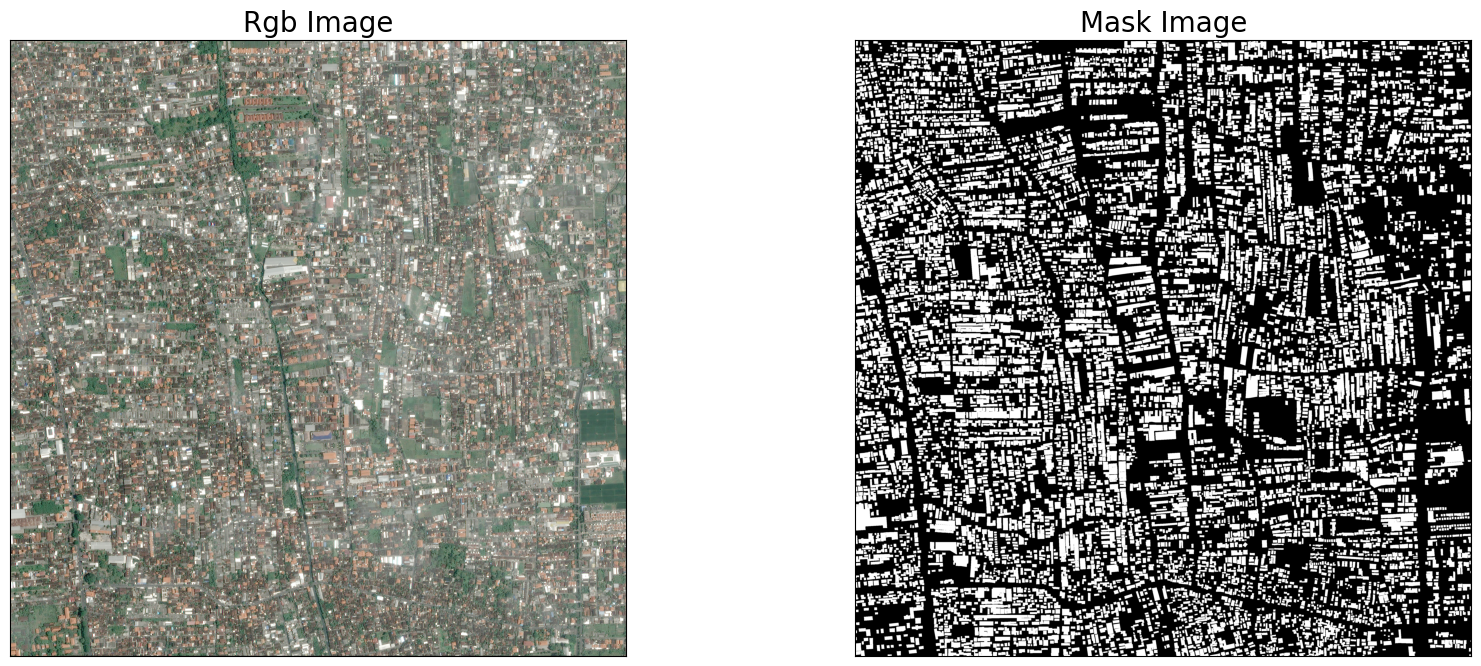

In [26]:
# Scalling and/or Stretching RGB Image Input, Convert rgba image to rgb
img_scalling(rgba_loc, rgb_out)
stretch_image_brightness(rgb_out, rgb_out)

# Shapefile to Mask Image
# Load the shapefile using geopandas
gdf = gpd.read_file(in_shp_path)

# Open the raster file
raster_path = rgb_out
with rs.open(raster_path) as src:
    # Reproject the shapefile to match the raster's CRS
    gdf = gdf.to_crs(src.crs)

    # Get the geometry of the shapefile
    geometry = gdf.geometry

    # Create a mask using the geometry and raster's shape
    mask = geometry_mask(geometry, out_shape=src.shape, transform=src.transform, invert=True)

    # Assign a specified label value to the areas within the shapefile
    label_value = (255, 255, 255)  # RGB value for the label
    mask_rgb = np.zeros((src.height, src.width, 3), dtype=np.uint8)
    mask_rgb[mask] = label_value

    # Transpose the mask_rgb array
    mask_rgb = np.transpose(mask_rgb, (2, 0, 1))

# Save the mask as a raster
with rs.open(mask_path, 'w', driver='GTiff', width=src.width, height=src.height,
                   count=3, crs=src.crs, transform=src.transform, dtype=rs.uint8) as dst:
    dst.write(mask_rgb)

# Calling Image file and getting informations
img_info = img_coord(img_dir)
mask_info = img_coord(mask_path)

print('Image informations (Image X, Image Y)(X, Y, GSD_X, GSD_Y) = ', img_info)
print('Mask informations  (Image X, Image Y)(X, Y, GSD_X, GSD_Y) = ', mask_info)

visualize(
    rgb_image = np.squeeze(tiff.imread(img_dir)),
    mask_image = np.squeeze(tiff.imread(mask_path))
)

#### Data Patching and Folder Splitting

In [27]:
# Using GeoPatch Function: TrainPatch class
# Patch size example: 128, 256, 512

# Feeding data to be patched
patch = TrainPatch(image=img_dir, label=mask_path,
                   patch_size=512, stride=512, channel_first=True
                   )

# Displaying shape and size of input image
patch.data_dimension()

# Displaying the number of orginal image patches
patch.patch_info()

# Saving image as Geotiff file
patch.save_Geotif(patch_folder, only_label=True)

# Split folder and data into train, test, and validate
"""
Folder structure will be:
          train/
                label/
                patch/
          test/
                label/
                patch/
          ...
"""
splitfolders.ratio(patch_folder, output = split_folder,
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

############################################
 the shape of image is: (3, 4001, 4001) 
 the shape of label is: (3, 4001, 4001) 
############################################
       
#######################################################################################
The effective X-dimension of the input data for patch generation is from 0 to 4513
The effective Y-dimension of the input data for patch generation is from 0 to 4513
The number of total non-augmented patches that can be generated
based on patch size (512*512) and stride (512) is "49"
#######################################################################################
                                                                        


Patch Counter: 81 Patch [00:02, 28.33 Patch/s]


#######################################################################################
81 patches, which are %165 of totall patches, are saved as ".tif" format in "/content/drive/MyDrive/SEERI\/content/drive/MyDrive/SEERI/tiff/_prep/R2C1/"
#######################################################################################


Copying files: 162 files [00:02, 72.43 files/s]


##### Visualizing Sample Image and Mask

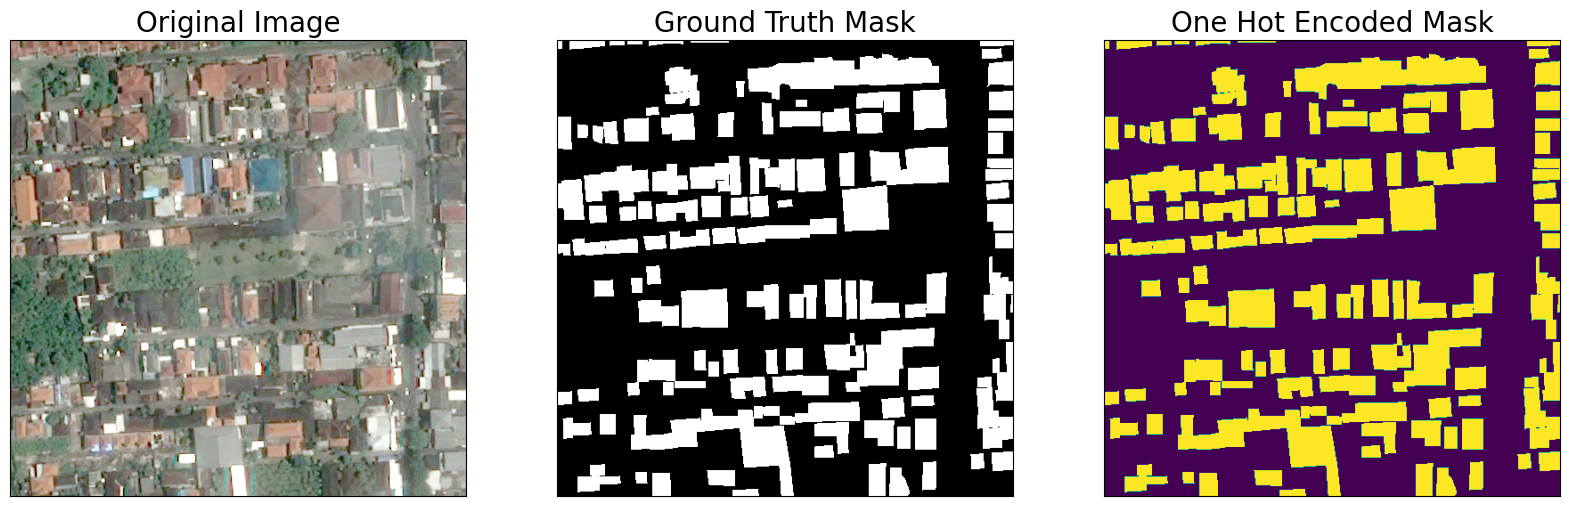

In [28]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Training the Model

#### Get Data Loaders for Train, Test, and Validation

In [42]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataset = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset)

#### Training

In [30]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if (i >= 3 and best_iou_score < valid_logs['iou_score']):
            best_iou_score = valid_logs['iou_score']
            torch.save(model, model_loc)

            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 8/8 [00:00<00:00, 11.85it/s, dice_loss - 0.4492, iou_score - 3.815e-13]

Epoch: 1
valid: 100%|██████████| 8/8 [00:00<00:00, 12.32it/s, dice_loss - 0.4213, iou_score - 3.815e-13]

Epoch: 2
valid: 100%|██████████| 8/8 [00:00<00:00,  8.29it/s, dice_loss - 0.4067, iou_score - 3.815e-13]

Epoch: 3
valid: 100%|██████████| 8/8 [00:00<00:00, 13.64it/s, dice_loss - 0.3985, iou_score - 3.815e-13]
Model saved!

Epoch: 4
valid: 100%|██████████| 8/8 [00:00<00:00, 13.01it/s, dice_loss - 0.4021, iou_score - 6.294e-05]
Model saved!

Epoch: 5
valid: 100%|██████████| 8/8 [00:00<00:00,  8.22it/s, dice_loss - 0.3987, iou_score - 3.719e-05]

Epoch: 6
valid: 100%|██████████| 8/8 [00:00<00:00, 11.78it/s, dice_loss - 0.3924, iou_score - 0.000206]
Model saved!

Epoch: 7
valid: 100%|██████████| 8/8 [00:00<00:00, 12.66it/s, dice_loss - 0.3716, iou_score - 0.000989]
Model saved!

Epoch: 8
valid: 100%|██████████| 8/8 [00:00<00:00,  8.13it/s, dice_loss - 0.374, iou_score - 0.000494

##### Plot Dice Loss & IoU Metric for Train and Validation

In [31]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3             4         5  \
dice_loss  0.488449  0.470216  0.454605  0.443098  4.301677e-01  0.419667   
iou_score  0.000002  0.000015  0.000010  0.000037  1.576742e-13  0.000022   

                      6         7             8         9  
dice_loss  4.056068e-01  0.400843  3.842965e-01  0.378243  
iou_score  4.069012e-07  0.000008  1.576742e-13  0.000002

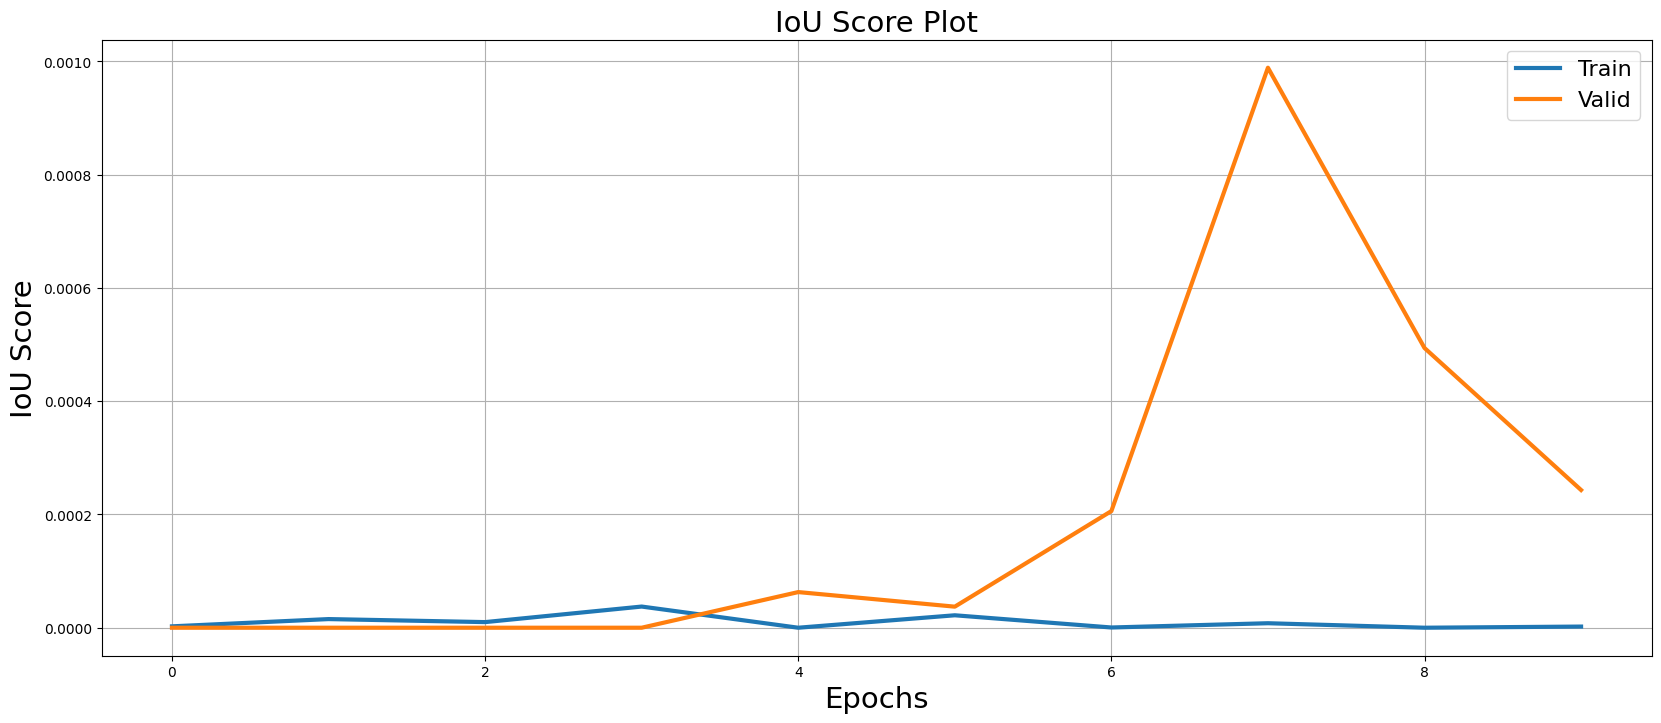

In [32]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

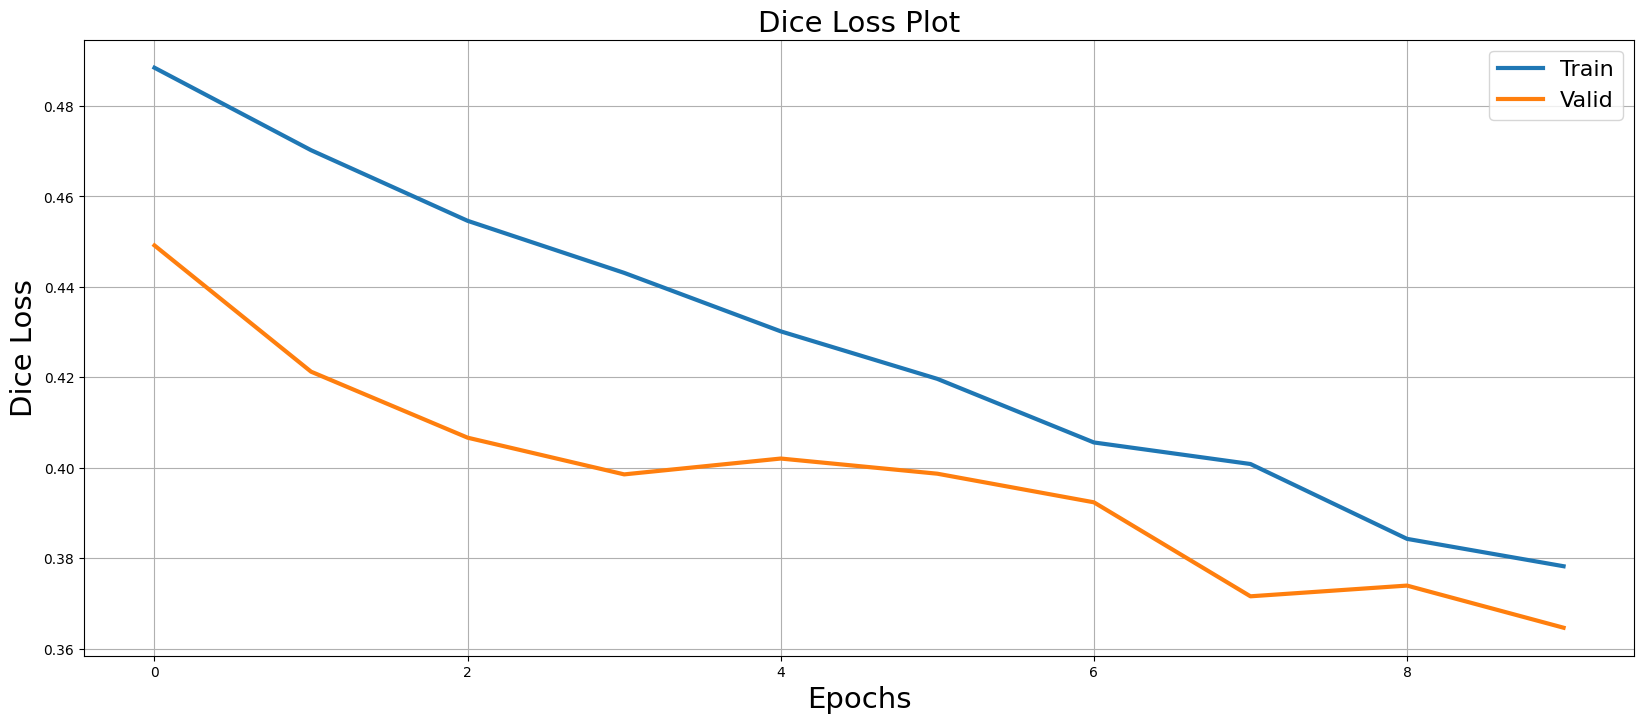

In [33]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

#### Model Evaluation on Test Dataset

In [34]:
# load best saved model checkpoint from the current run
if os.path.exists(best_model_loc): # best_model.pb
    best_model = torch.load(best_model_loc, map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


In [35]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 9/9 [00:00<00:00, 11.92it/s, dice_loss - 0.3178, iou_score - 0.0004323]
Evaluation on Test Data: 
Mean IoU Score: 0.0004
Mean Dice Loss: 0.3178


In [36]:
### Addition for exporting to ONNX format ###
# Fetch a batch of data from the test DataLoader

i_model = best_model.to(DEVICE)

images, masks = next(iter(test_dataloader))

# Move the input data to the same device as the model (CPU or GPU)
images = images.to(DEVICE)

# Export the model to ONNX format
try:
  torch.onnx.export(best_model,
            images,
            onnx_file_path,
            export_params=True,
            opset_version=11)

  print("Model exported to ONNX format.")
except Exception as e:
  print("Failed to export the model to ONNX format:", str(e))

# Trace the model and save to TorchScript format
try:
  script_model = torch.jit.trace(best_model, images)
  torch.jit.save(script_model, torch_script_path)
  print("Model saved in TorchScript format.")
except Exception as e:
  print("Failed to save the model in TorchScript format:", str(e))

### End of the Addition ###

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model exported to ONNX format.
Model saved in TorchScript format.


##### Sample Images Prediction

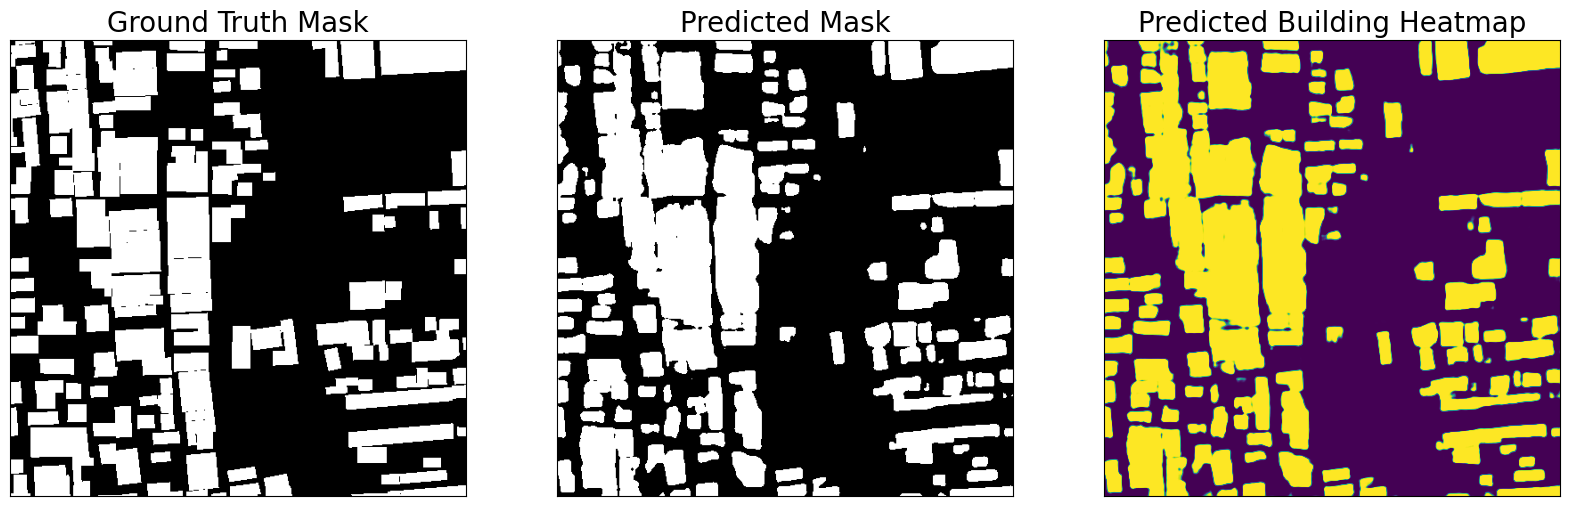

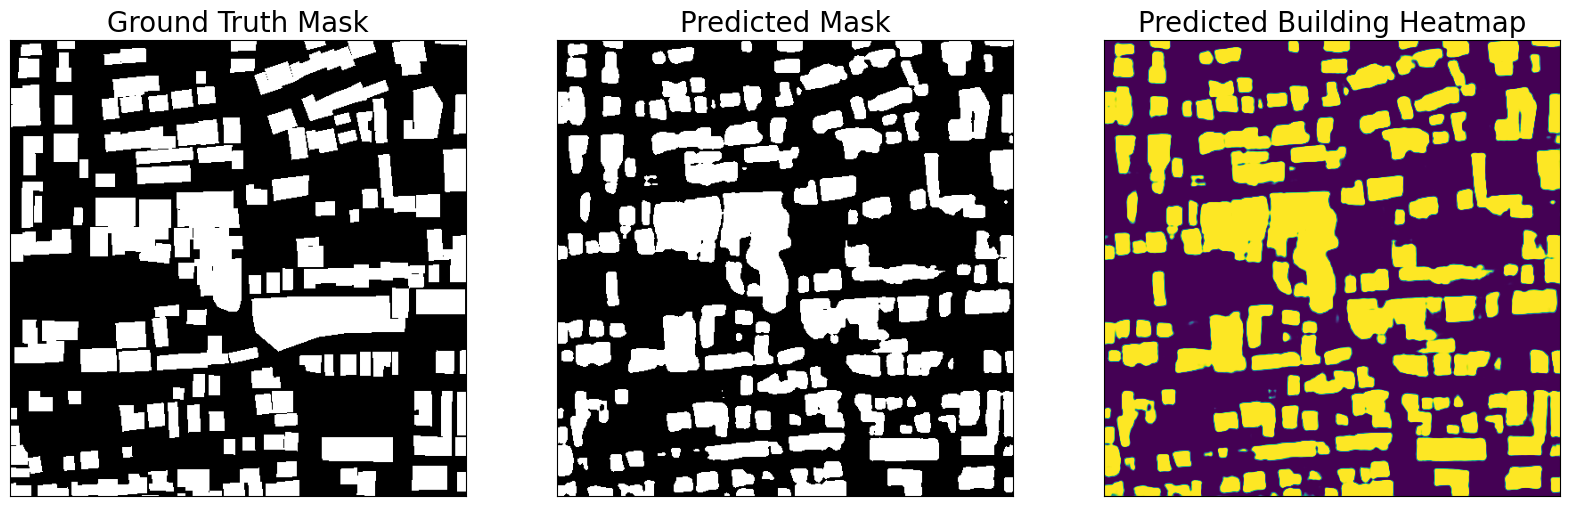

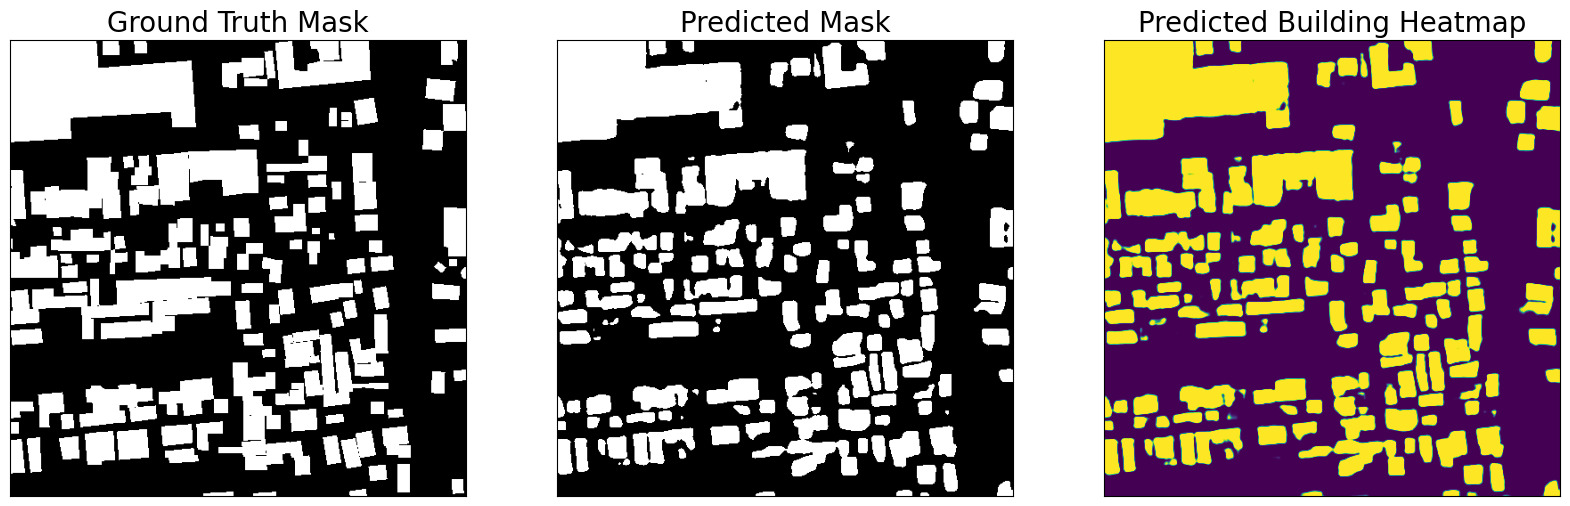

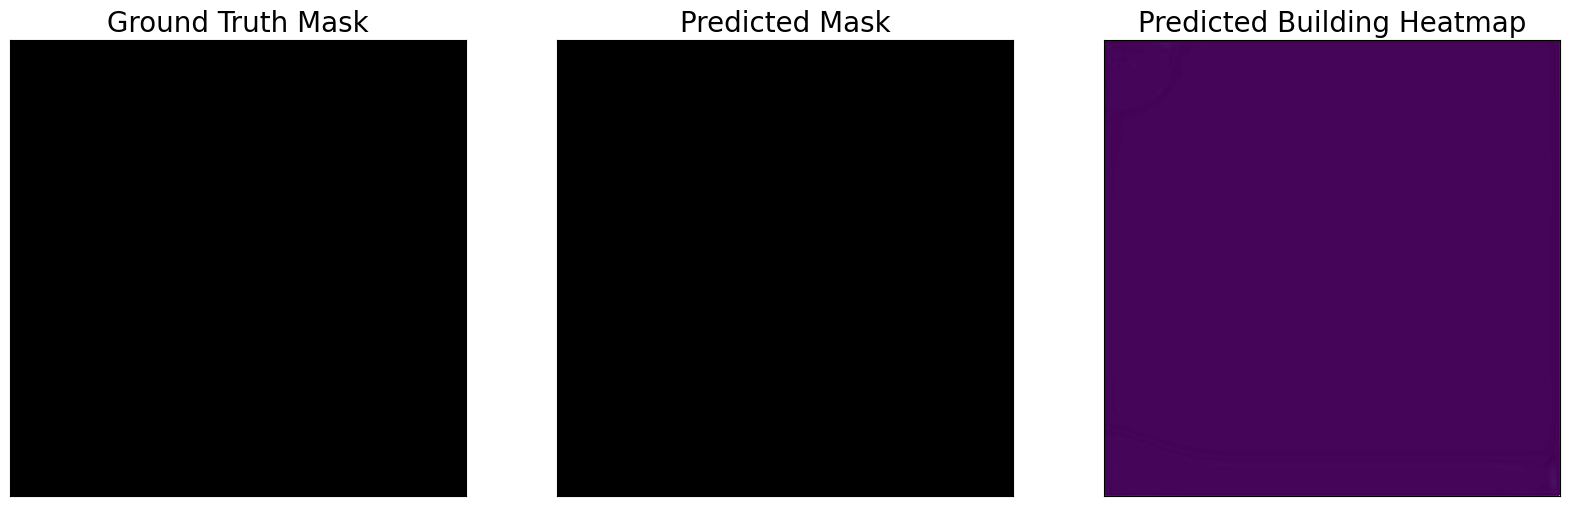

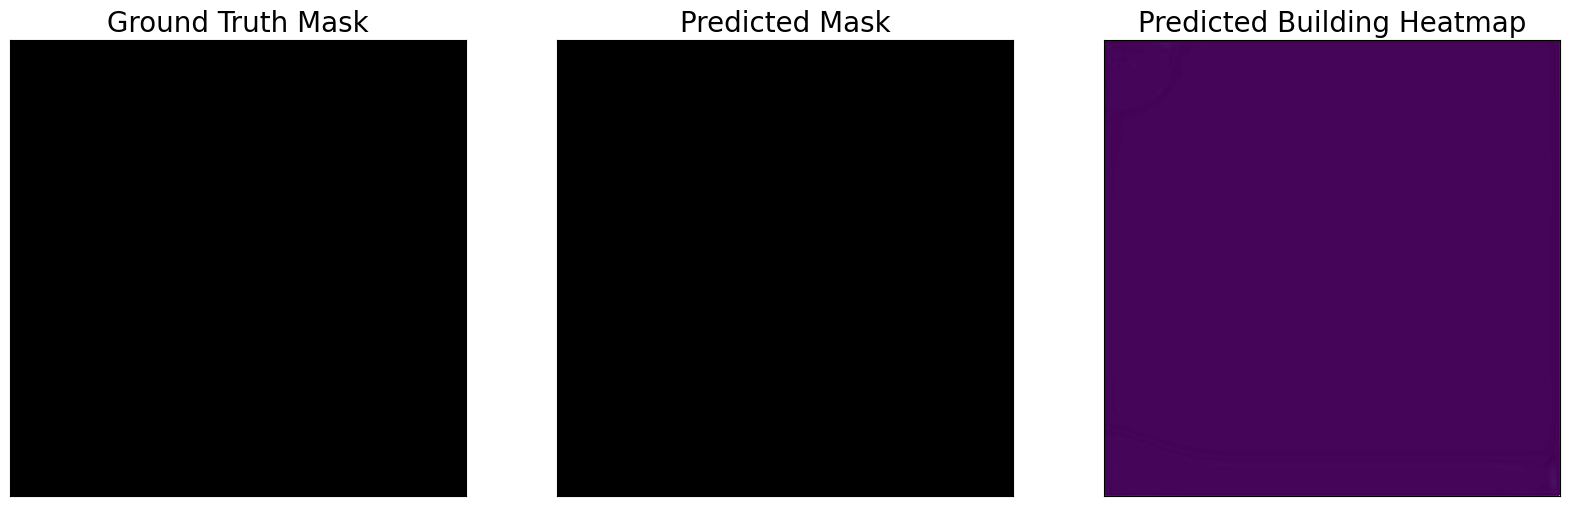

In [48]:
# Define the list of predetermined image indices you want to display
# predetermined_image_indices = [10, 20, 30, 40, 50]  # Replace with the desired indices
predetermined_image_indices = [1, 2, 3, 4, 5]

displayed_image_count = 0
for idx in predetermined_image_indices:
    image, gt_mask = test_dataset[idx]

    # Continue only if the image and gt_mask exist
    if image is not None and gt_mask is not None and displayed_image_count < 5:
        displayed_image_count += 1
        # image_vis = crop_image(test_dataset[idx][0].astype('uint8'))
        # image_vis = image
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        # Predict test image
        pred_mask = best_model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        pred_mask = np.transpose(pred_mask,(1,2,0))
        # Get prediction channel corresponding to building
        pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
        pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)) # , select_class_indices
        # Convert gt_mask from `CHW` format to `HWC` format
        gt_mask = np.transpose(gt_mask,(1,2,0))
        gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)) # , select_class_indices
        cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([gt_mask, pred_mask])[:,:,::-1])

        visualize(
            # original_image = image_vis,
            ground_truth_mask = gt_mask,
            predicted_mask = pred_mask,
            predicted_building_heatmap = pred_building_heatmap
        )

## Data Preparation and Prediction Process

### Data Preparation

#### Preparation and Visualizing Data Input

Image informations (Image X, Image Y)(X, Y, GSD_X, GSD_Y) =  [4001, 4001, 303861.0, 9039571.0, 0.5, -0.5]


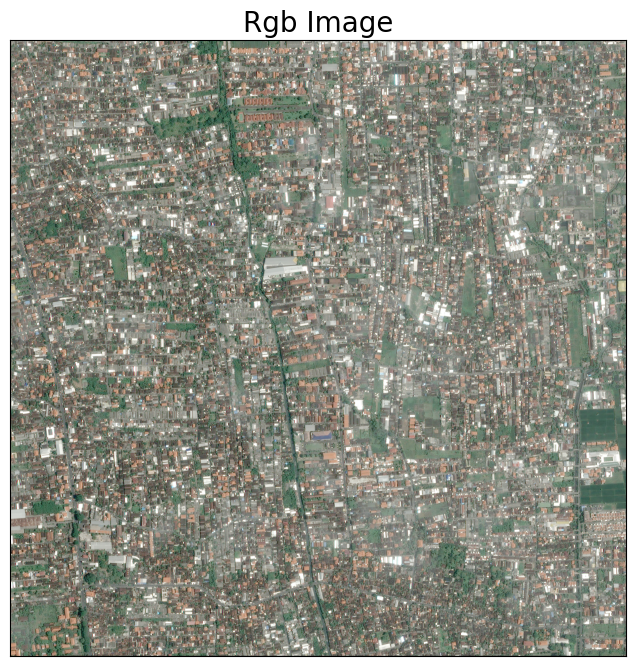

In [75]:
# Scalling and/or Stretching RGB Image Input, Convert rgba image to rgb
img_scalling(rgba_loc, rgb_out)
stretch_image_brightness(rgb_out, rgb_out)

# Calling Image file and getting informations
img_info = img_coord(img_dir)

print('Image informations (Image X, Image Y)(X, Y, GSD_X, GSD_Y) = ', img_info)

visualize(
    rgb_image = np.squeeze(tiff.imread(img_dir))
)

#### Image Patching

In [76]:
# Using GeoPatch Function: PredictionPatch class
# Patch size example: 128, 256, 512

# Feeding data to be patched
patch = PredictionPatch(image=img_dir, patch_size=512,
                        stride=512, channel_first=True)

# Displaying shape and size of input image
patch.data_dimension()

# Displaying the number of orginal image patches
patch.patch_info()

# Saving image as Geotiff file
patch.save_Geotif(patch_folder)

############################################
 the shape of image is: (3, 4001, 4001) 
############################################
       
#######################################################################################
The effective X-dimension of the input data for patch generation is from 0 to 4513
The effective Y-dimension of the input data for patch generation is from 0 to 4513
The number of total non-augmented patches that can be generated
based on patch size (512*512) and stride (512) is "49"
#######################################################################################
                                                                        


Patch Counter: 64 Patch [00:01, 37.76 Patch/s]

#######################################################################################
64 patches, which are %130 of totall patches, are saved as ".tif" format in "/content/drive/MyDrive/SEERI\/content/drive/MyDrive/SEERI/tiff/_prep/pred_data/SEERI_R2C1/"
#######################################################################################


### Predicting the Images

In [77]:
# load best saved model checkpoint from the current run
if os.path.exists(best_model_loc):
    best_model = torch.load(best_model_loc, map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


In [78]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
predict_dataset = PredBuildingsDataset(
    pred_patch,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

if not os.path.exists(preds_folder):
    os.makedirs(preds_folder)

In [79]:
# Iterate over the images in the predict_dataset
with tqdm.tqdm(range(len(predict_dataset)), desc="Image Processing", unit=" Image") as pbar:
    for idx in pbar:
        image = predict_dataset[idx]

        # Predict the test image
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pred_mask = best_model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()

        # Convert pred_mask from `CHW` format to `HWC` format
        pred_mask = np.transpose(pred_mask, (1, 2, 0))

        # Get prediction channel corresponding to building
        pred_building_heatmap = pred_mask[:, :, select_classes.index('building')]
        pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

        # Convert pred_mask from `HWC` format to `CHW` format
        pred_mask = np.transpose(pred_mask, (2, 0, 1))

        # Get the corresponding input image path and metadata image path
        input_image_path = predict_dataset.image_paths[idx]

        # Open the input image and read its metadata
        with rs.open(input_image_path) as src:
            src_metadata = src.meta

            # Create a new single-channel image with the same dimensions as the input image
            single_channel_mask = pred_mask[0].copy()  # Assuming pred_mask is (1, H, W)

            # Set the desired metadata properties for the new image
            new_metadata = {
                'width': src_metadata['width'],
                'height': src_metadata['height'],
                'count': 1,  # Set count to 1 for the single channel image
                'crs': src_metadata['crs'],
                'transform': src_metadata['transform'],
                'dtype': src_metadata['dtype']  # Use the dtype of the predicted mask
            }

            # Write the new single-channel mask as a TIFF file with the same name as the input image
            # Change the extension to ".tif"
            input_image_name = os.path.splitext(os.path.basename(input_image_path))[0]
            new_image_path = os.path.join(preds_folder, f"{input_image_name}.tif")
            with rs.open(new_image_path, 'w', **new_metadata) as dst:
                dst.write(single_channel_mask, 1)  # Write the single channel mask


        # Update progress bar
        pbar.set_postfix({"Processed": idx + 1})
        pbar.update(1)

    # Calculate and display the percentage of images processed
    total_images = len(predict_dataset)
    processed_percentage = int((total_images / total_images) * 100)
    print(f"Processed {total_images} images, which is {processed_percentage}% of total images.")

Image Processing: 100%|██████████| 64/64 [00:05<00:00, 11.42 Image/s, Processed=64]

Processed 64 images, which is 100% of total images.


#### Visualizing Sample Predicted Image

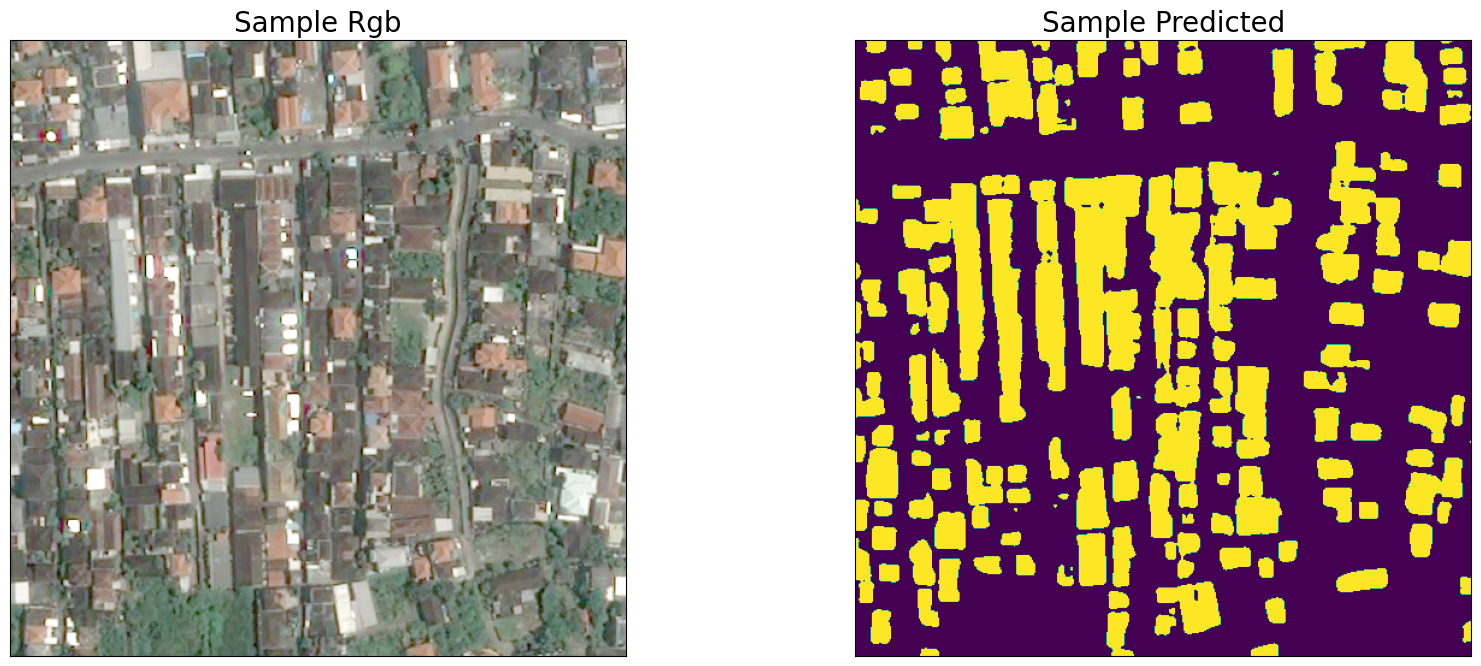

In [80]:
num_imgs = len(os.listdir(preds_folder))
img_num = random.randint(0, num_imgs-1)

visualize(
    sample_rgb = np.squeeze(tiff.imread(os.path.join(pred_patch, str(img_num) + '_img.tif'))),
    sample_predicted = np.squeeze(tiff.imread(os.path.join(preds_folder, str(img_num) + '_img.tif')))
)

### Regularization of Predicted Images

#### Updating Variables for Regularization

Updating variables.py as input for regularize.py

In [82]:
# Update variables.py WITH USERS PATHS

with open(projectRegDir + '/variables.py', 'w') as f:
    f.write('# CONFIGURE THE PATHS HERE: \n\n')
    f.write('# TRAINING \n')
    f.write('DATASET_RGB = ' + '"' + str(TRAIN_IMG_DIR + '/*.tif' + '"') + '\n')
    f.write('DATASET_GTI = ' + '"' + str(TRAIN_MASK_DIR + '/*.tif' + '"') + '\n')
    f.write('DATASET_SEG = ' + '"' + str(PREDICTIONS_DIR + '/*.tif' + '"') + '\n')
    f.write('\n')
    f.write('DEBUG_DIR = ' + '"' + str('./debug/') + '"' + '\n')
    f.write('\n')
    f.write('# INFERENCE \n')
    f.write('INF_RGB = ' + '"' + str(TEST_IMG_DIR + '/*.tif' + '"') + '\n')
    f.write('INF_SEG = ' + '"' + str(PREDICTIONS_DIR + '/*.tif' + '"') + '\n')
    f.write('INF_OUT = ' + '"' + str(REGULARIZATION_DIR + '"') + '\n')
    f.write('\n')
    f.write('MODEL_ENCODER = ' + '"' + str(ENCODER) + '"' + '\n')
    f.write('MODEL_GENERATOR = ' + '"' + str(GENERATOR) + '"' + '\n')
    f.close()

print("variables.py created with users paths...")

variables.py created with users paths...


#### Run projectRegularization

In [89]:
# RUN REGULARIZATION - takes around 6-8 minutes
# change the command below: provide the absolute path for regularize.py

# !python {proj_dir}/projectRegularization/regularize.py

# try
import subprocess # move the import to the initialization if run succcessfully

# Set the absolute path to regularize.py
script_path = os.path.join(proj_dir, 'projectRegularization/regularize.py')

# Suppress the output by redirecting stdout and stderr to /dev/null
completed_process = subprocess.run(["python", script_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Check if the process has completed successfully
if completed_process.returncode == 0:
    print("Regularization script has finished successfully.")
else:
    print("Regularization script encountered an error.")

Regularization script has finished successfully.


##### Visualizing Regularization Result

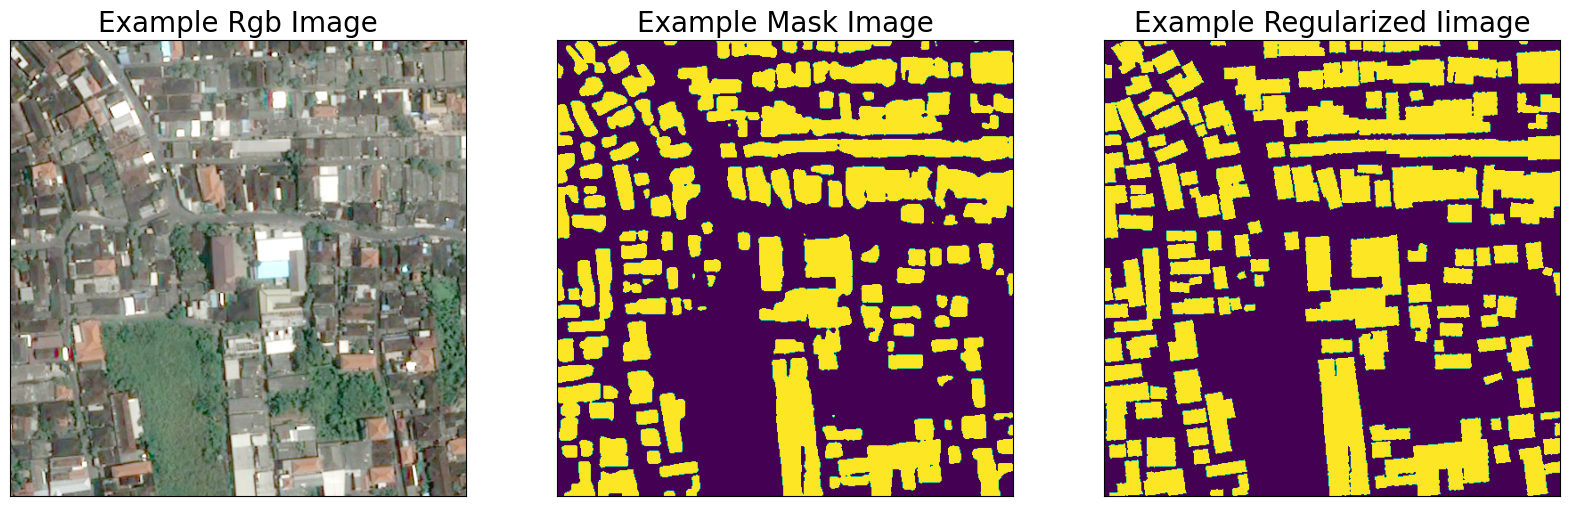

In [90]:
num_imgs = len(os.listdir(REGULARIZATION_DIR))
img_num = random.randint(0, num_imgs-1)

visualize(
    example_rgb_image = np.squeeze(tiff.imread(os.path.join(TEST_IMG_DIR, str(img_num) + '_img.tif'))),
    example_mask_image = np.squeeze(tiff.imread(os.path.join(PREDICTIONS_DIR, str(img_num) + '_img.tif'))),
    example_regularized_iimage = np.squeeze(tiff.imread(os.path.join(REGULARIZATION_DIR, str(img_num) + '_img.tif')))
)

### Merging Patches and Vectorization

#### Merging Patches

In [86]:
# Merging Patches
# Read the metadata from an existing TIFF image
with rs.open(img_dir) as src:
    existing_meta = src.meta.copy()

# Create a list to hold the opened patch datasets
patch_datasets = []

# Iterate over the files in the patch folder
for file_name in os.listdir(REGULARIZATION_DIR):
    if file_name.endswith('.tif') or file_name.endswith('.tiff'):
        patch_path = os.path.join(REGULARIZATION_DIR, file_name)
        patch_ds = rs.open(patch_path)
        patch_datasets.append(patch_ds)

# Merge the patch datasets into a single mosaic
mosaic, out_transform = merge(patch_datasets)

# Update the metadata of the mosaic with the existing metadata
out_meta = existing_meta
out_meta.update({
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'count': 1,
    'transform': out_transform
})

# Save the final mosaic as a TIFF image
with rs.open(raster_path, 'w', **out_meta) as dest:
    dest.write(mosaic)

##### Visualizing Mosaic Output

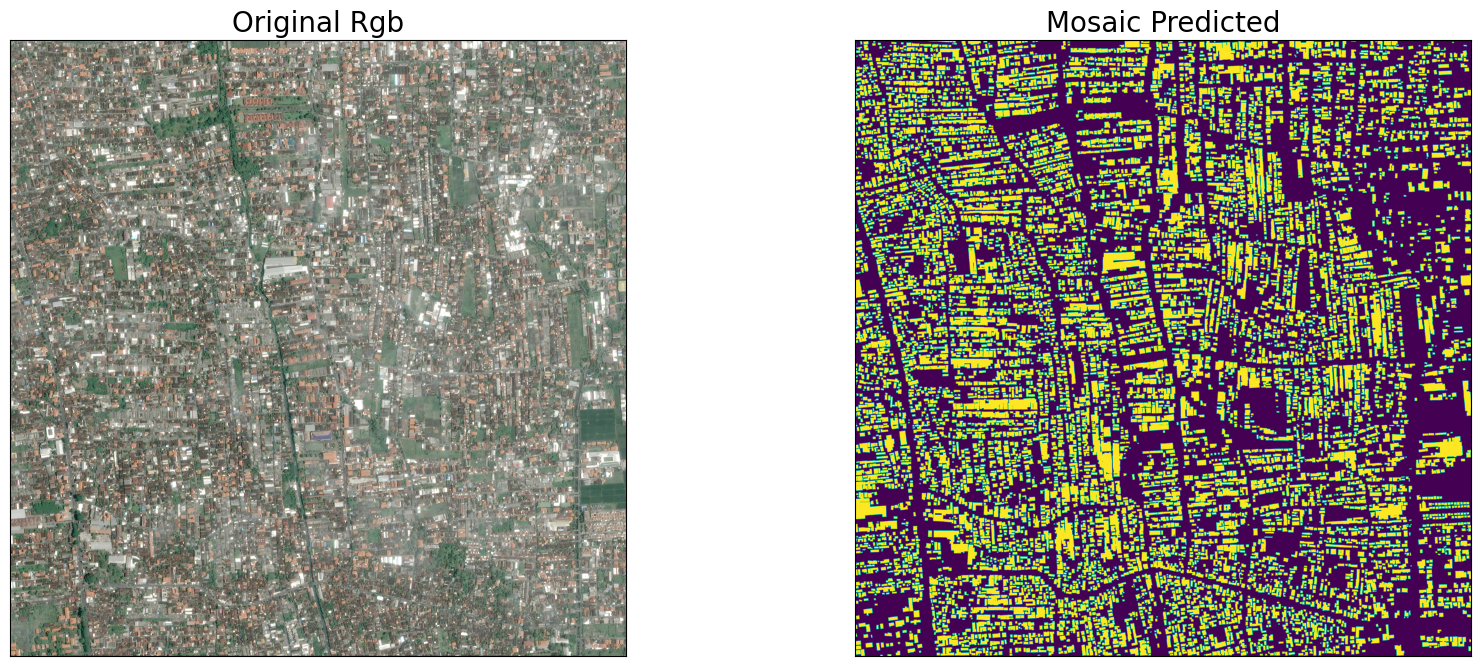

In [87]:
visualize(
    original_rgb = np.squeeze(tiff.imread(img_dir)),
    mosaic_predicted = np.squeeze(tiff.imread(raster_path))
)

### Polygonization from Predicted Image

#### To Shapefile

In [88]:
"""
Polygonization problem from raster image:
- The vector results appear jagged
"""

# Read the raster using rasterio
with rasterio.open(raster_path) as src:
    # Read the raster bands
    image = src.read(1)

    # Generate the polygon shapes from the raster
    shapes = rasterio.features.shapes(image, transform=src.transform)

    # Create a list to store valid geometries and IDs
    geometries = []
    ids = []

    # Iterate over the generated shapes
    for geom, value in shapes:
        # Convert the shape to a Shapely geometry
        geometry = shp(geom)

        # Check if the geometry is valid
        if geometry.is_valid:
            geometries.append(geometry)
            ids.append(value)

    # Create a GeoDataFrame from the geometries and IDs
    gdf = gpd.GeoDataFrame(geometry=geometries, data={'ids': ids})

    # Find the index of the geometry with the largest area
    largest_area_index = gdf['geometry'].area.idxmax()

    # Drop the geometry with the largest area from the GeoDataFrame
    gdf.drop(index=largest_area_index, inplace=True)

    # Assign the CRS to the GeoDataFrame
    gdf.crs = src.crs.to_string()

    # Set the geometry column name
    gdf.geometry.name = 'geometry'

# Write the GeoDataFrame to a shapefile
gdf.to_file(shapefile_path)

#### To PostGIS
The code won't run on google collab, the code must be copied to your local machine

In [ ]:
%%capture
!pip install sqlalchemy==1.3.24 geoalchemy2==0.7.0 psycopg2==2.9.1

In [ ]:
# import rasterio
# import geopandas as gpd
# from shapely.geometry import shape as shp
from sqlalchemy import create_engine
from geoalchemy2 import Geometry

# Define the path to the input raster on your local machine
raster_path = '/path/to/your/mosaic_img/on_your_machine/proj_img_Output.tif'

# Read the raster using rasterio
with rs.open(raster_path) as src:
    # Read the raster bands
    image = src.read(1)

    # Generate the polygon shapes from the raster
    shapes = rs.features.shapes(image, transform=src.transform)

    # Create a list to store valid geometries and IDs
    geometries = []
    ids = []

    # Iterate over the generated shapes
    for geom, value in shapes:
        # Convert the shape to a Shapely geometry
        geometry = shp(geom)

        # Check if the geometry is valid
        if geometry.is_valid:
            geometries.append(geometry)
            ids.append(value)

    # Get the CRS from the source raster
    crs = src.crs.to_string()

# Create a GeoDataFrame from the geometries and IDs with the obtained CRS
gdf = gpd.GeoDataFrame(geometry=geometries, data={'ids': ids}, crs=crs)

# Find the index of the geometry with the largest area
largest_area_index = gdf['geometry'].area.idxmax()

# Drop the geometry with the largest area from the GeoDataFrame
gdf.drop(index=largest_area_index, inplace=True)

# Database credentials
db_name = 'postgis_30_sample'
db_user = 'postgres'
db_password = '1234'
db_host = 'localhost'
db_port = '5432'

# Create the connection URL
db_url = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create a database engine
engine = create_engine(db_url)

# Upload GeoDataFrame to PostGIS
gdf.to_postgis('bali_buildings', con=engine, schema='public', if_exists='replace', index=False, dtype={'geometry': Geometry('POLYGON', srid=gdf.crs.to_epsg())})

# Close the database engine
engine.dispose()